In [1]:
import pandas as pd
from property_prediction import SevenNetPropertiesPreditcor
from torch_geometric.loader import DataLoader

from dataset import AtomsToGraphCollater
import sevenn

import torch.optim as optim
import torch.nn as nn
from train import train
from nn import SimplePeriodicNetwork


df = pd.read_csv('sevennet_slopes.csv')
df.loc[df['v1_Li_slope'] <= 0, 'v1_Li_slope'] = 1e-4

from dataset import build_dataset
dataset = build_dataset(df, temp = 1000)

Cache path set to "./cache". To change, set PFP_CACHE environment variable.


100%|██████████| 179/179 [00:00<00:00, 1140.05it/s]


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]

batch_size = 10

In [3]:
checkpoint = sevenn.util.pretrained_name_to_path('7net-0')
sevennet_model, sevennet_config = sevenn.util.model_from_checkpoint(checkpoint)


In [4]:
sevennet_predictor = SevenNetPropertiesPreditcor(sevennet_model = sevennet_model, sevennet_config = sevennet_config)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
train_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.01, properties_predictor = sevennet_predictor)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
val_dataloader.collate_fn = AtomsToGraphCollater(cutoff = 5, noise_std=0.01, properties_predictor = sevennet_predictor)

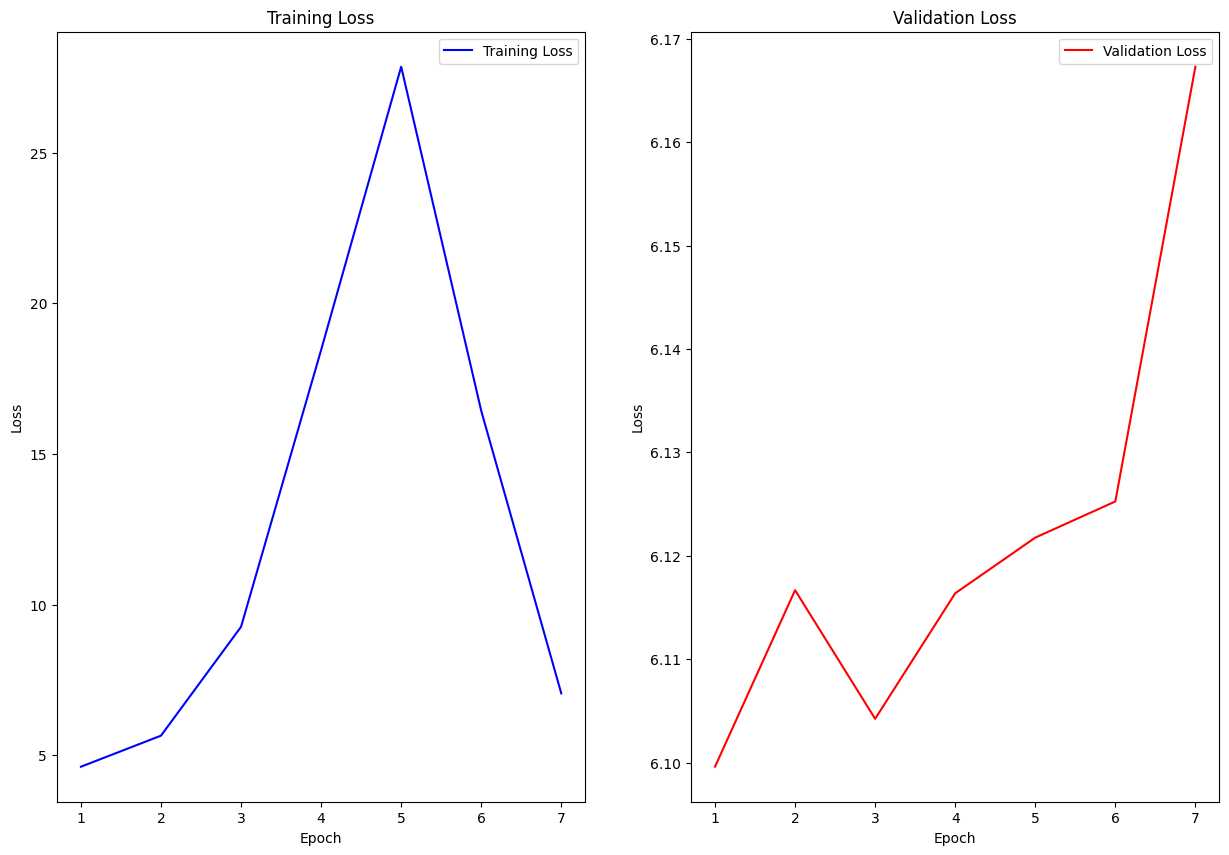

graph_build (1): 100%|██████████| 10/10 [00:00<00:00, 76.49it/s]


In [ ]:
radial_cutoff = 5

net = SimplePeriodicNetwork(
    irreps_in="1x1o",  
    irreps_out="1x0e",  # Single scalar (L=0 and even parity) to output (for example) energy
    max_radius=radial_cutoff, # Cutoff radius for convolution
    num_neighbors=10.0,  # scaling factor based on the typical number of neighbors
    pool_nodes=True,  # We pool nodes to predict total energy
)

criterion = nn.MSELoss()  # Example: Mean Squared Error
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 50

train(net, train_dataloader, val_dataloader, optimizer, criterion, num_epochs)